In [1]:
import torch 
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt 
from tqdm import tqdm

device="cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchvision.__version__)

2.0.0
0.15.0


In [2]:
from pathlib import Path
from helper_functions import walk_through_dir

data_path=Path("data/")
image_path = data_path / "militaryvsother"
walk_through_dir(image_path)

There are 3 directories and 0 images in 'data\militaryvsother'.
There are 2 directories and 0 images in 'data\militaryvsother\test'.
There are 0 directories and 1281 images in 'data\militaryvsother\test\millitary'.
There are 0 directories and 1511 images in 'data\militaryvsother\test\other'.
There are 2 directories and 0 images in 'data\militaryvsother\train'.
There are 0 directories and 5125 images in 'data\militaryvsother\train\millitary'.
There are 0 directories and 6045 images in 'data\militaryvsother\train\other'.
There are 2 directories and 0 images in 'data\militaryvsother\validation'.
There are 0 directories and 1602 images in 'data\militaryvsother\validation\millitary'.
There are 0 directories and 1889 images in 'data\militaryvsother\validation\other'.


In [3]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/militaryvsother/train'),
 WindowsPath('data/militaryvsother/test'))

Random image path: data\militaryvsother\validation\millitary\millitary_0_614.jpeg
Image class: millitary
Image height: 256
Image width: 256


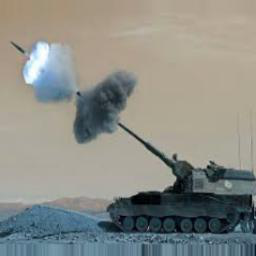

In [4]:
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*/*.jpeg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

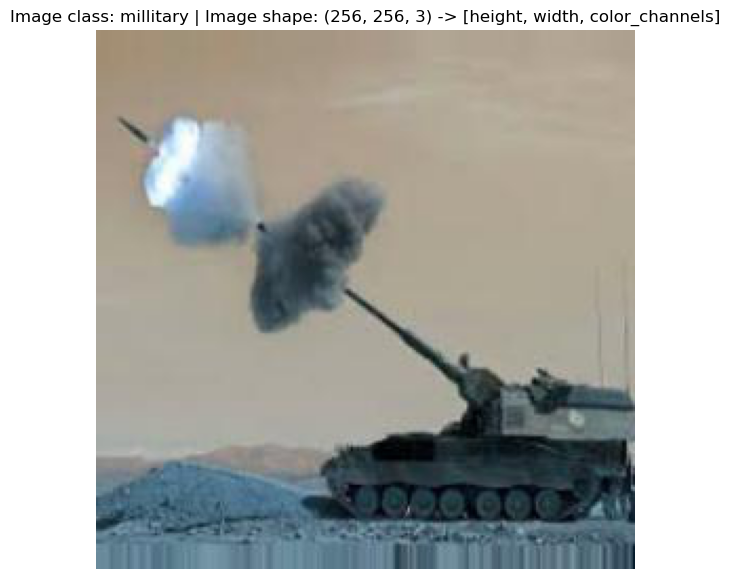

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [6]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transformer=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

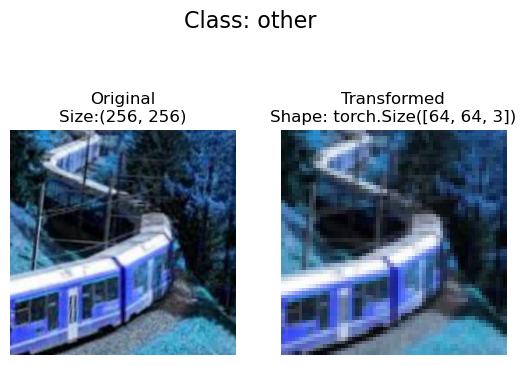

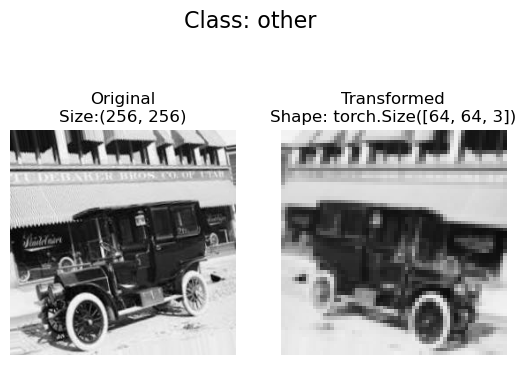

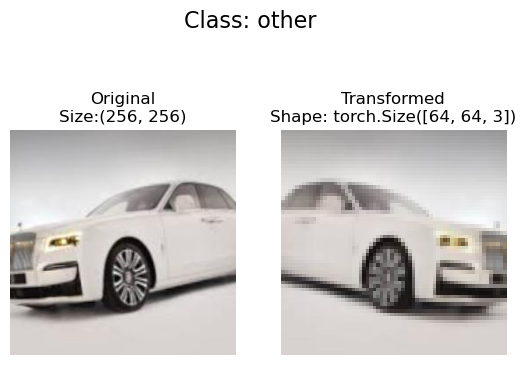

In [7]:
from helper_functions import plot_transformed_images

plot_transformed_images(image_path_list,transform=data_transformer)

In [8]:
from torchvision import datasets

train_data=datasets.ImageFolder(root=train_dir,
                                transform=data_transformer,
                                target_transform=None)

test_data=datasets.ImageFolder(root=test_dir,
                               transform=data_transformer)
print(f"Train Data:\n{train_data}\nTest Data:\n{test_data}")

Train Data:
Dataset ImageFolder
    Number of datapoints: 11170
    Root location: data\militaryvsother\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test Data:
Dataset ImageFolder
    Number of datapoints: 2792
    Root location: data\militaryvsother\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [9]:
#train data size, test data size and percentage of test to train
len(train_data),len(test_data),(len(test_data)/(len(train_data)+len(test_data))*100)

(11170, 2792, 19.997135080933965)

In [10]:
classes=train_data.classes
class_dict=train_data.class_to_idx
classes,class_dict

(['millitary', 'other'], {'millitary': 0, 'other': 1})

In [11]:
from torch.utils.data import DataLoader
import os
BATCH_SIZE=128
NUM_WORKERS=os.cpu_count()

train_dataloader=DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            num_workers=NUM_WORKERS,
                            shuffle=True)


test_dataloader=DataLoader(dataset=test_data,
                           batch_size=BATCH_SIZE,
                           num_workers=NUM_WORKERS,
                           shuffle=False)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x23545caf850>,
 <torch.utils.data.dataloader.DataLoader at 0x235462f0160>)

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from timeit import default_timer as timer
from helper_functions import train_step,test_step,print_train_time,accuracy_fn

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define your binary classification ResNet model
class BinaryResNet18(nn.Module):
    def __init__(self):
        super(BinaryResNet18, self).__init__()
        resnet18 = models.resnet18(pretrained=True)
        # Change the final fully connected layer to output 2 classes for binary classification
        resnet18.fc = nn.Linear(resnet18.fc.in_features, 2)
        self.resnet18 = resnet18

    def forward(self, x):
        return self.resnet18(x)

# Initialize the model
binary_resnet = BinaryResNet18().to(device)

# Define your loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(binary_resnet.parameters(), lr=0.001, momentum=0.9)

# Assuming you have a DataLoader for your training dataset (train_data_loader)
# Replace this with your actual DataLoader and dataset structure
# Make sure to properly preprocess your dataset (e.g., normalization and augmentation)
# if needed, according to the original ResNet18 preprocessing.

# Example:
# train_data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training loop
train_time_start_model_0=timer()

epochs=10

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1}\n-------------")
    train_step(model=binary_resnet,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=binary_resnet,
              data_loader=train_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
    
train_time_end_model_0=timer()


c:\Users\TRON PCH\miniconda3\envs\ai_env2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\TRON PCH\miniconda3\envs\ai_env2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
-------------
Train loss: 0.43166 | Train acc: 79.28%


 10%|█         | 1/10 [00:48<07:17, 48.65s/it]


Test loss: 0.2544, Test acc 90.1143
Epoch: 2
-------------
Train loss: 0.22961 | Train acc: 90.40%


 20%|██        | 2/10 [01:37<06:29, 48.68s/it]


Test loss: 0.1494, Test acc 94.5845
Epoch: 3
-------------
Train loss: 0.13889 | Train acc: 94.72%


 30%|███       | 3/10 [02:26<05:42, 48.91s/it]


Test loss: 0.0896, Test acc 97.4254
Epoch: 4
-------------
Train loss: 0.09550 | Train acc: 96.73%


 40%|████      | 4/10 [03:15<04:53, 48.91s/it]


Test loss: 0.0551, Test acc 98.7837
Epoch: 5
-------------
Train loss: 0.06294 | Train acc: 98.03%


 50%|█████     | 5/10 [04:04<04:04, 48.82s/it]


Test loss: 0.0342, Test acc 99.3430
Epoch: 6
-------------
Train loss: 0.04134 | Train acc: 98.91%


 60%|██████    | 6/10 [04:51<03:13, 48.43s/it]


Test loss: 0.0201, Test acc 99.6538
Epoch: 7
-------------
Train loss: 0.02901 | Train acc: 99.29%


 70%|███████   | 7/10 [05:39<02:24, 48.21s/it]


Test loss: 0.0138, Test acc 99.8313
Epoch: 8
-------------
Train loss: 0.02093 | Train acc: 99.57%


 80%|████████  | 8/10 [06:27<01:36, 48.13s/it]


Test loss: 0.0092, Test acc 99.9023
Epoch: 9
-------------
Train loss: 0.01574 | Train acc: 99.72%


 90%|█████████ | 9/10 [07:15<00:47, 47.95s/it]


Test loss: 0.0060, Test acc 99.9645
Epoch: 10
-------------
Train loss: 0.01246 | Train acc: 99.84%


100%|██████████| 10/10 [08:03<00:00, 48.32s/it]


Test loss: 0.0049, Test acc 99.9556


In [24]:
from helper_functions import eval_model


binary_resnet_results=eval_model(model=binary_resnet,
                           data_loader=test_dataloader,
                           loss_fn=loss_fn,
                           accuracy_fn=accuracy_fn)
binary_resnet_results

100%|██████████| 22/22 [00:22<00:00,  1.03s/it]


{'model_name': 'BinaryResNet18',
 'model_loss': 0.12211698293685913,
 'model_acc': 95.95443618881119}

In [25]:
def make_predictions(model:torch.nn.Module,
                     data: list,
                     device:torch.device=device):
    pred_probs= []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            #Prepare the sample (add a batch dimension and pass to target device)
            sample = torch.unsqueeze(sample,dim=0).to(device)

            #Forward pass (model outputs raw logits)
            pred_logit=model(sample)

            #Get pred probs(logit to pred probs)
            pred_prob=torch.softmax(pred_logit.squeeze(),dim=0)

            #Turn pred probs in to prediction labels(targets)
            
            #Get pred_prob off the GPU for futher calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

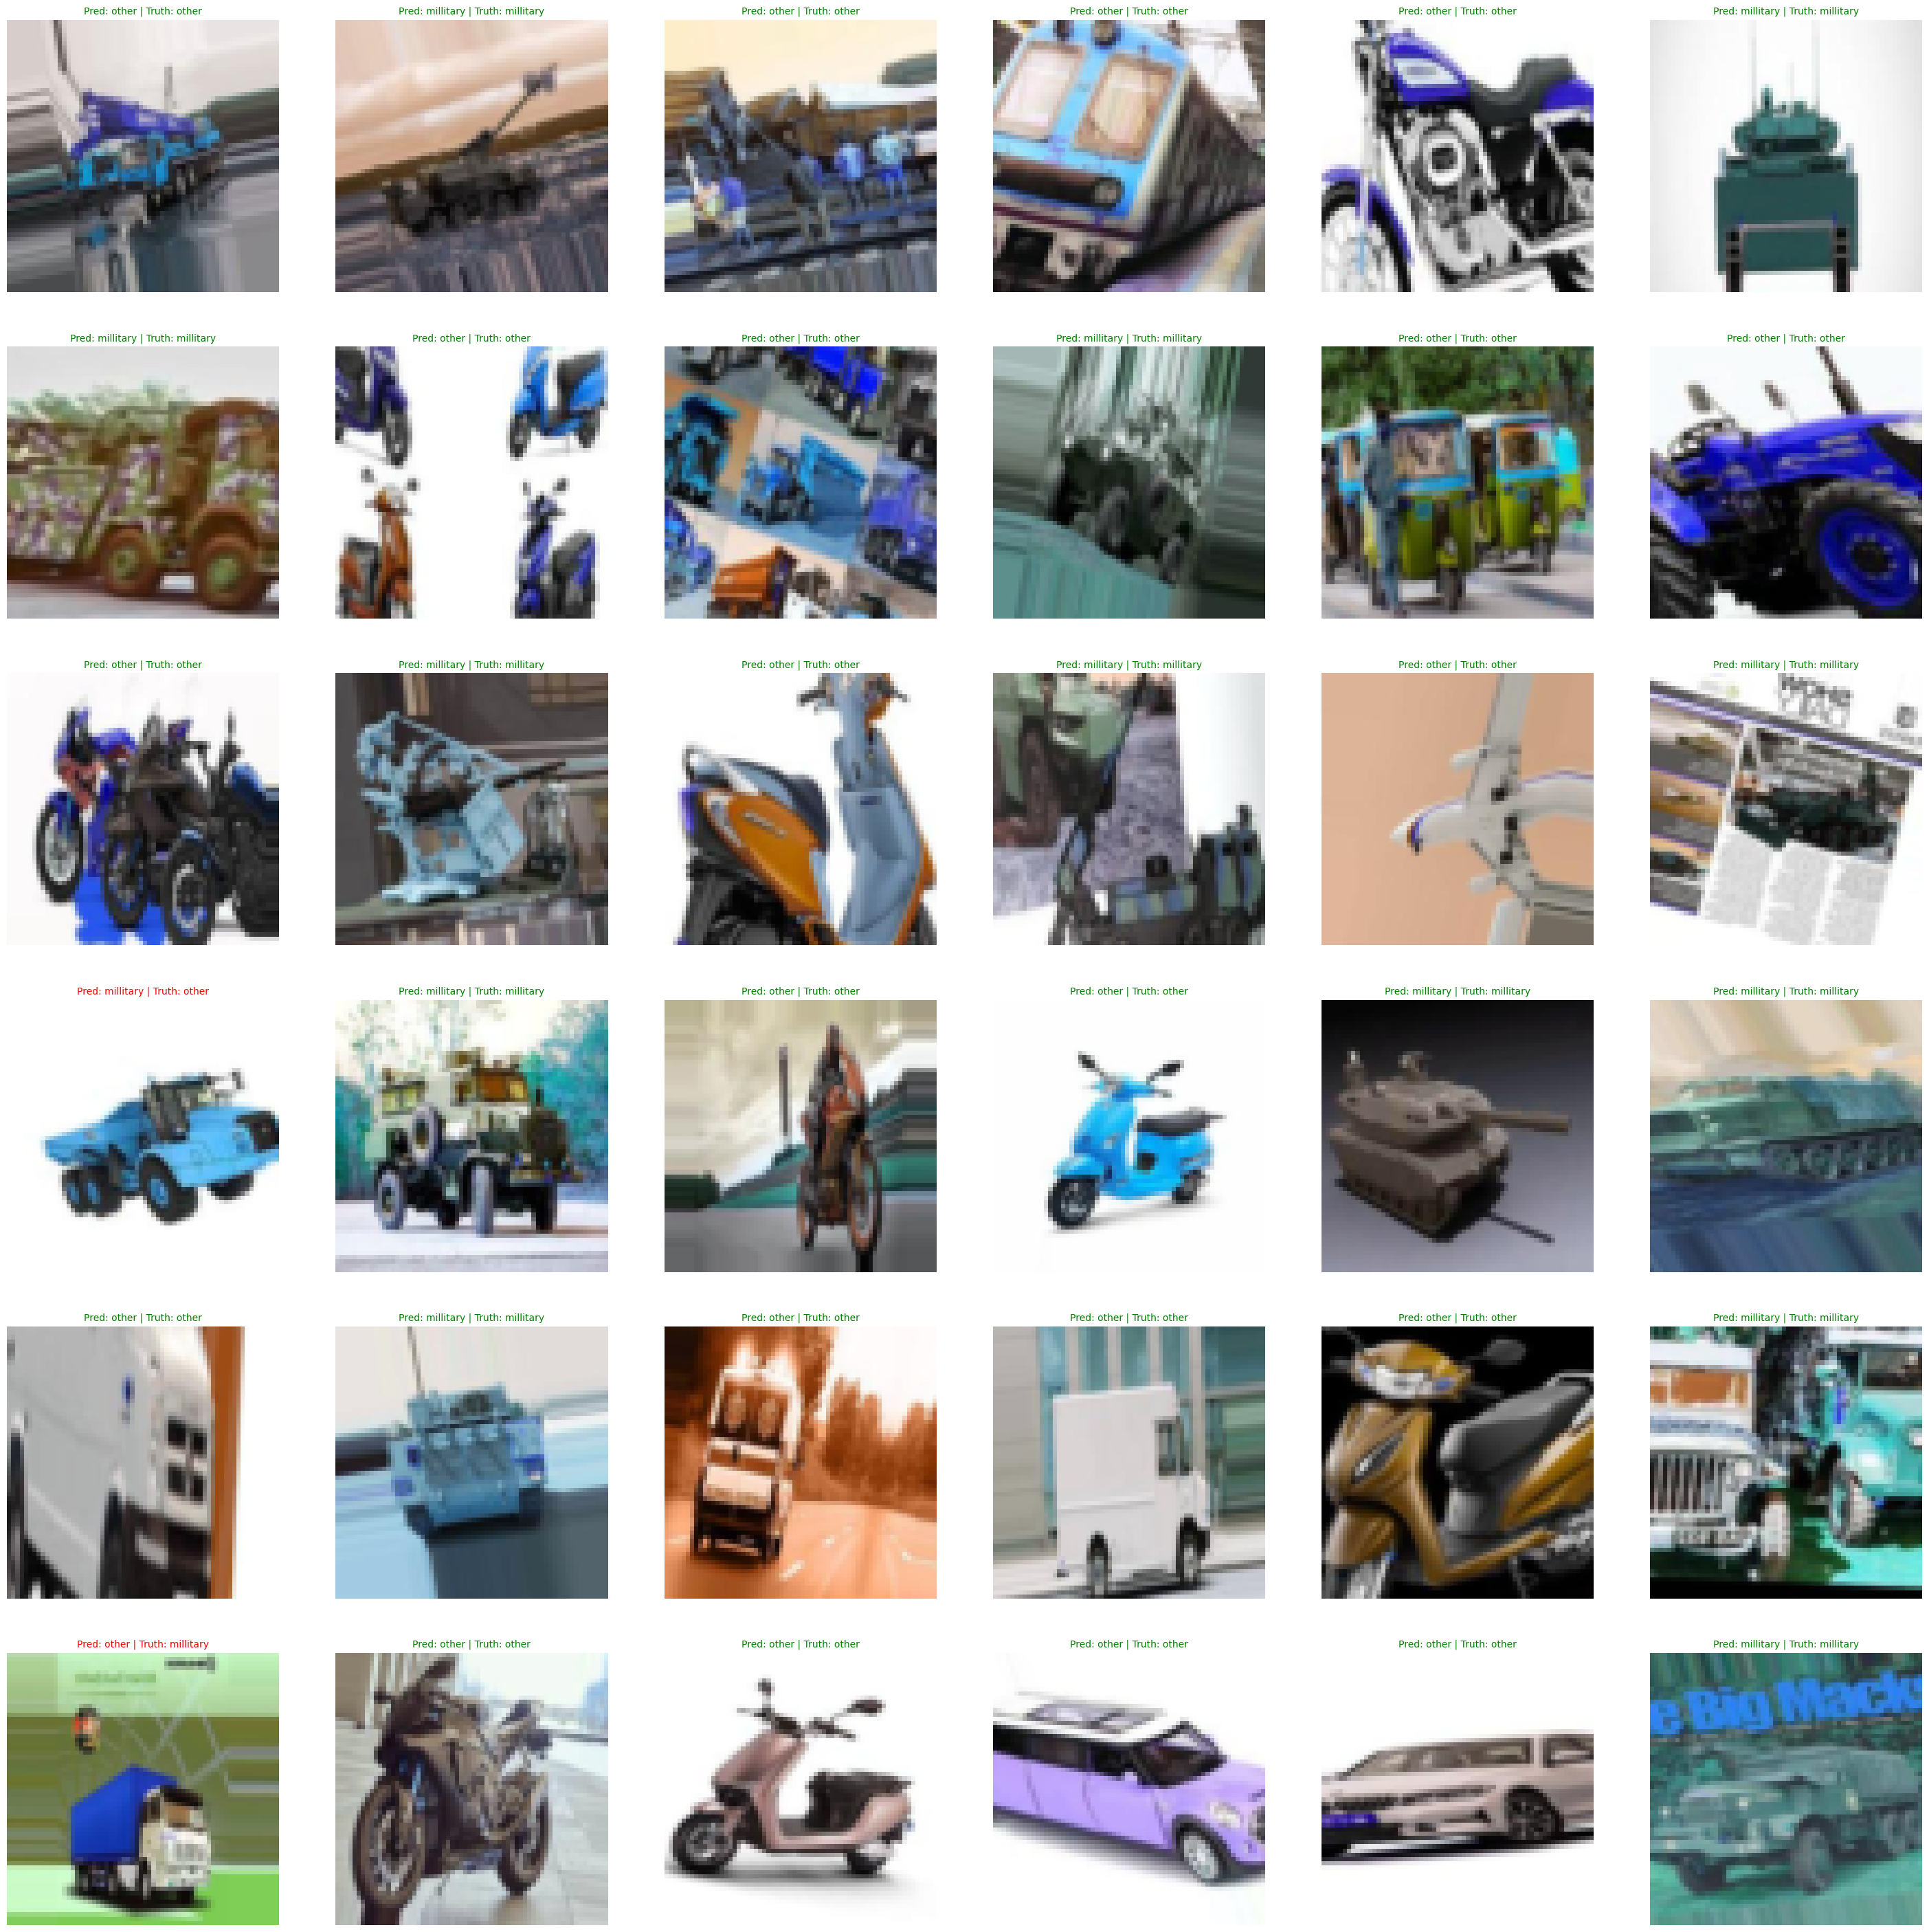

In [26]:

import random
#random.seed(42)

test_samples=[]
test_labels=[]

for sample, label in random.sample(list(test_data),k=36):
    test_samples.append(sample)
    test_labels.append(label)

#View the first sample shape
test_samples[0].shape

pred_probs=make_predictions(model=binary_resnet,
                            data=test_samples,
                            device=device)


pred_classes = pred_probs.argmax(dim=1)

plt.figure(figsize=(36, 36))
nrows = 6
ncols = 6
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(np.transpose(sample, (1, 2, 0)), cmap="gray")


  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = classes[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = classes[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="green") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="red") # red text if wrong
  plt.axis(False)

In [27]:
binary_resnet_results

{'model_name': 'BinaryResNet18',
 'model_loss': 0.12211698293685913,
 'model_acc': 95.95443618881119}

In [28]:
from pathlib import Path 
import torch
#Create a model directory

MODEL_PATH =Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

#Create a model save path
MODEL_NAME="binary_resnet_model.pth"
MODEL_SAVE_PATH=MODEL_PATH/MODEL_NAME
MODEL_SAVE_PATH

#Save the model state dict

print(f"Saving model to: {MODEL_SAVE_PATH}")

torch.save(obj=binary_resnet.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models\binary_resnet_model.pth
